<a href="https://colab.research.google.com/github/naguzmans/opportunistic-atm/blob/master/01_Preprocess_Flight_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Dependencies

In [ ]:
!pip install pyspark
!pip install haversine
!pip install contextily
%cd /content/drive/MyDrive/opportunistic-utm

# Load CSV Data Into Spark

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType, BooleanType, LongType, DateType, IntegerType
from pyspark.sql.functions import udf
import os
import glob
import datetime
from haversine import haversine, Unit, inverse_haversine
import numpy as np

spark = SparkSession.builder.appName('opensky').getOrCreate()
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

schema = StructType([ \
    StructField('time', LongType(), False), \
    StructField('icao24', StringType(), True), \
    StructField('lat', FloatType(), True), \
    StructField('lon', FloatType(), True), \
    StructField('velocity', FloatType(), True), \
    StructField('heading', FloatType(), True), \
    StructField('vertrate', FloatType(), True), \
    StructField('callsign', StringType(), True), \
    StructField('onground', BooleanType(), True), \
    StructField('alert', BooleanType(), True), \
    StructField('spi', BooleanType(), True), \
    StructField('squawk', FloatType(), True), \
    StructField('baroaltitude', FloatType(), True), \
    StructField('geoaltitude', FloatType(), True), \
    StructField('lastposupdate', FloatType(), True), \
    StructField('lastcontact', FloatType(), True), \
    StructField('hour', LongType(), True) \
])

def epoch_to_utc(hour_in_unix_time):
  return datetime.datetime.utcfromtimestamp(hour_in_unix_time)
utc = udf(epoch_to_utc, DateType())

folder_path = '/content/drive/MyDrive/opportunistic-utm/data'
file_names = []

for filename in glob.iglob(folder_path + '/**/*.csv', recursive=True):
  file_names.append(filename)

opensky_df = spark.read.option('header', True).csv(path=file_names, schema=schema)
opensky_df = opensky_df.withColumn('timestamp', utc('hour'))

# opensky_df = opensky_df.sort('time')
opensky_df.show(10)

+----------+------+---------+------------+--------+---------+--------+--------+--------+-----+-----+------+------------+-----------+-------------+-----------+----------+----------+
|      time|icao24|      lat|         lon|velocity|  heading|vertrate|callsign|onground|alert|  spi|squawk|baroaltitude|geoaltitude|lastposupdate|lastcontact|      hour| timestamp|
+----------+------+---------+------------+--------+---------+--------+--------+--------+-----+-----+------+------------+-----------+-------------+-----------+----------+----------+
|1497139225|400755|51.918453| -0.11943708| 72.8715|255.27702|-3.90144|  TOM6VY|   false|false|false|7774.0|     1005.84|     998.22|  1.4971392E9|1.4971392E9|1497139200|2017-06-11|
|1497139226|400755|51.918274| -0.12046814|72.37406|255.17352|-3.90144|  TOM6VY|   false|false|false|7774.0|     1005.84|     998.22|  1.4971392E9|1.4971392E9|1497139200|2017-06-11|
|1497139227|400755|51.918083|-0.121398926|72.37406|255.17352|-3.90144|  TOM6VY|   false|false|f

**Verify schema**

In [4]:
opensky_df.printSchema()

root
 |-- time: long (nullable = true)
 |-- icao24: string (nullable = true)
 |-- lat: float (nullable = true)
 |-- lon: float (nullable = true)
 |-- velocity: float (nullable = true)
 |-- heading: float (nullable = true)
 |-- vertrate: float (nullable = true)
 |-- callsign: string (nullable = true)
 |-- onground: boolean (nullable = true)
 |-- alert: boolean (nullable = true)
 |-- spi: boolean (nullable = true)
 |-- squawk: float (nullable = true)
 |-- baroaltitude: float (nullable = true)
 |-- geoaltitude: float (nullable = true)
 |-- lastposupdate: float (nullable = true)
 |-- lastcontact: float (nullable = true)
 |-- hour: long (nullable = true)
 |-- timestamp: date (nullable = true)



**Check rows and columns**

In [ ]:
print((opensky_df.count(), len(opensky_df.columns)))

(73780207, 17)


# Plot Hourly Data

In [5]:
from pyspark.sql.functions import countDistinct
import matplotlib.pyplot as plt
from pyspark.sql.functions import days
%config InlineBackend.figure_format = 'retina'

subset = opensky_df.groupBy('timestamp').agg(countDistinct('callsign'))
df = subset.toPandas()
df = df.sort_values(by=['timestamp']).reset_index(drop=True)
df.head()

,timestamp,count(callsign)
0,2017-01-01,249
1,2017-01-02,300
2,2017-01-03,258
3,2017-01-04,253
4,2017-01-05,269


Text(0.5, 1.0, 'Luton Airport Area - Number of Daily Flights')

<Figure size 432x288 with 0 Axes>

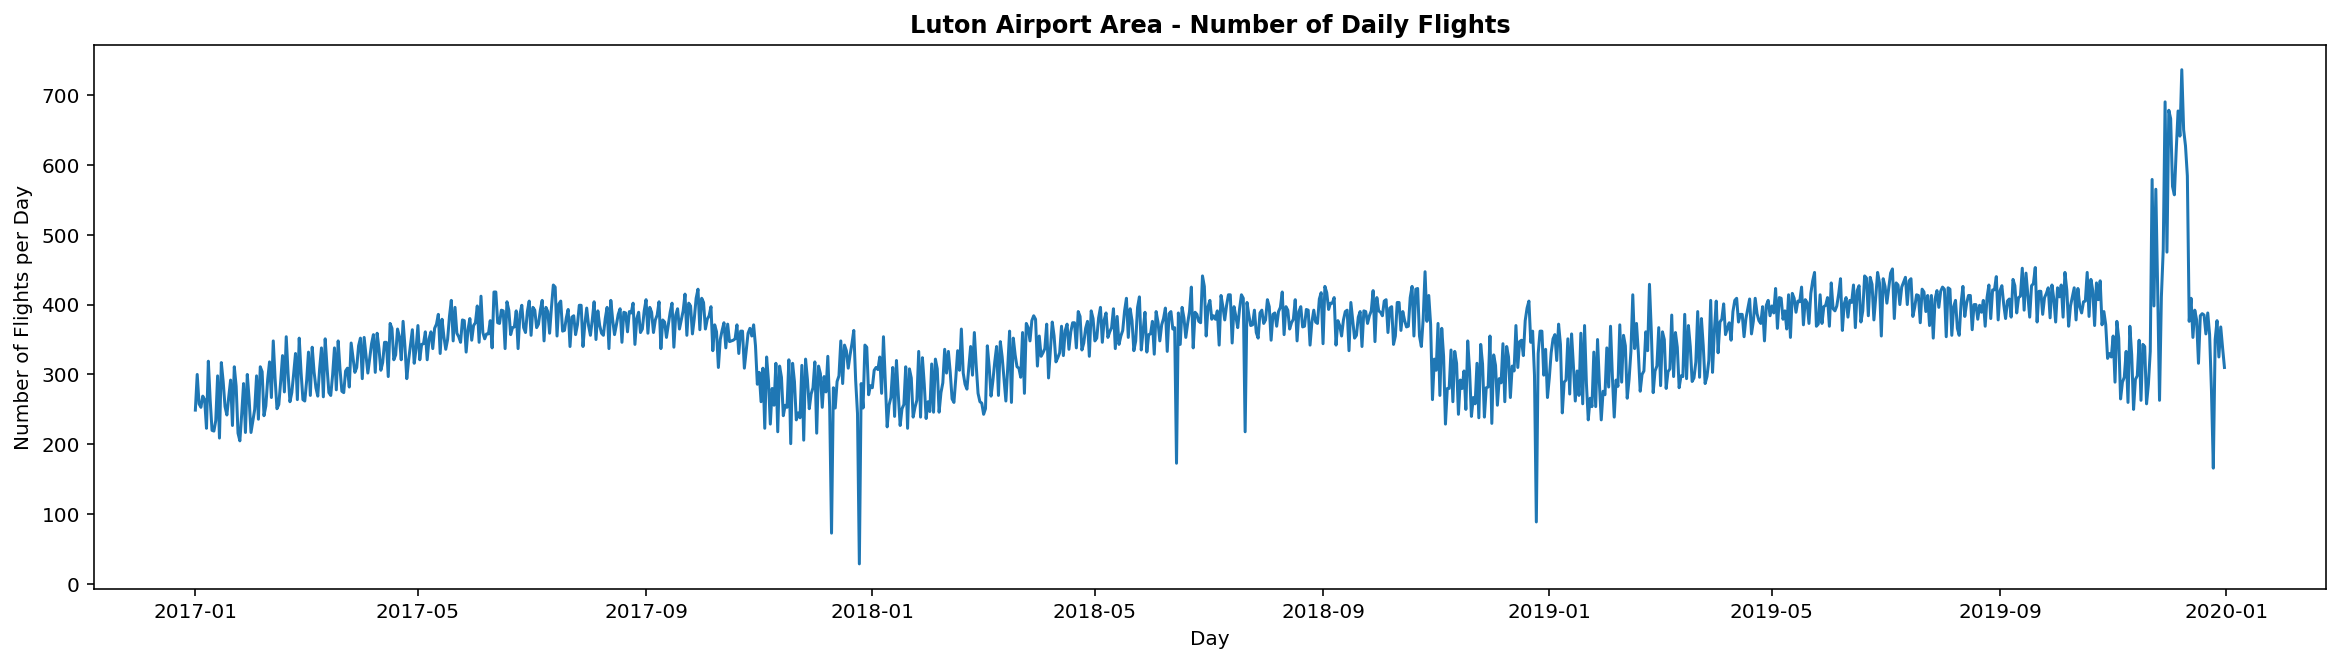

In [6]:
plt.figure()
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(df['timestamp'], df['count(callsign)'])
ax.set_xlabel('Day')
ax.set_ylabel('Number of Flights per Day')
ax.set_title('Luton Airport Area - Number of Daily Flights', fontweight='bold')

# Grid Data

A grid of 100px by 100px will be created and flights will be 'pixelated' to create a traffic map. Only an area of 5km by 5km around Luton Airport will be considered.

**PySpark Functions**

In [7]:
from pyspark.sql.functions import udf

def calculate_west_east_distance(destination_longitude):
  return haversine(min_coord, (min_coord[0], destination_longitude), unit=Unit.METERS) # (lat, lon)
we_distance = udf(calculate_west_east_distance, FloatType())

def calculate_north_south_distance(destination_latitude):
  return haversine(min_coord, (destination_latitude, min_coord[1]), unit=Unit.METERS) # (lat, lon)
ns_distance = udf(calculate_north_south_distance, FloatType())

def calculate_pixel_distance(destination_distance):
  return math.floor(destination_distance/grid_size)
px_distance = udf(calculate_pixel_distance, IntegerType())

def calculate_pixel_altitude(destination_altitude):
  altitude_level = math.floor((destination_altitude-160)/grid_size)
  if altitude_level >= 0:
    return altitude_level
  else:
    return 0
px_altitude = udf(calculate_pixel_altitude, IntegerType())

In [ ]:
from datetime import timezone
from datetime import datetime
from haversine import haversine, Unit, inverse_haversine
from pyspark.sql.types import StructType, StructField, StringType, FloatType, BooleanType, LongType, DateType, IntegerType
import math
from pyspark.sql.functions import count
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import numpy as np
%config InlineBackend.figure_format = 'retina'
from IPython.display import clear_output
import os
from subsampler import subsampler

# Calculate distances to airport
airport = (51.87626460000001, -0.3717470999999932) # Luton
diag_distance = 3.5
min_coord = inverse_haversine(airport, diag_distance, np.pi * 1.25)
max_coord = inverse_haversine(airport, diag_distance, np.pi * .25)
min_lat, max_lat, min_lon, max_lon = (min_coord[0], max_coord[0], min_coord[1], max_coord[1])

# Query
year = 2019
month = 10
days = np.linspace(1,31,31)
grid_size = 50 # in meters

for day in tqdm(days):
  hour_start = datetime(year, month, int(day), 0, 0, 0).replace(tzinfo=timezone.utc).timestamp()
  hour_end = datetime(year, month, int(day), 23, 59, 59).replace(tzinfo=timezone.utc).timestamp()

  day_subset = opensky_df.where(
                                (opensky_df.lat >= min_lat) &
                                (opensky_df.lat < max_lat) &
                                (opensky_df.lon >= min_lon) &
                                (opensky_df.lon < max_lon) &
                                (opensky_df.geoaltitude >= 0) & 
                                (opensky_df.geoaltitude < 1000) &
                                (opensky_df.hour >= hour_start) &
                                (opensky_df.hour <= hour_end)
                              )

  # def epoch_to_utc(hour_in_unix_time):
  #   return datetime.datetime.utcfromtimestamp(hour_in_unix_time)
  # utc = udf(epoch_to_utc, DateType())

  # opensky_df = opensky_df.withColumn('timestamp', utc('hour'))
  # opensky_df = opensky_df.withColumn('altitude', ft_to_m('geoaltitude'))
  day_subset = day_subset.withColumn('we_distance', we_distance('lon'))
  day_subset = day_subset.withColumn('ns_distance', ns_distance('lat'))
  day_subset = day_subset.withColumn('we_px', px_distance('we_distance'))
  day_subset = day_subset.withColumn('ns_px', px_distance('ns_distance'))
  day_subset = day_subset.withColumn('alt_px', px_altitude('geoaltitude'))

  epoch_hour = hour_start # start hour
  # hour_subset = subsampler(day_subset.toPandas()).groupby(['hour', 'alt_px', 'ns_px', 'we_px']).agg({'callsign': 'count'}).reset_index()
  hour_subset = day_subset.toPandas()

  cmap = plt.cm.get_cmap('brg', 10)
  for i in range(0, 24):
    matrix = np.zeros((20,100,100))

    image_subset = hour_subset[hour_subset['hour'] == epoch_hour].reset_index(drop=True)
    # image_subset = image_subset.groupby(['alt_px', 'ns_px', 'we_px']).agg({'icao24': 'count'}).reset_index()
    callsigns = image_subset.groupby('callsign')['time'].count().reset_index()['callsign'].tolist()
    try: # Some image_subset could be 0 length
      for callsign in callsigns:
        callsign_filtered = image_subset[image_subset['callsign'] == callsign].reset_index(drop=True)
        callsign_filtered = subsampler(callsign_filtered, 50)
        for j in range(0, len(callsign_filtered)):
          matrix[callsign_filtered['alt_px'][j]][callsign_filtered['ns_px'][j]][callsign_filtered['we_px'][j]] = 1
    except:
      pass
    
    # cmap = mpl.colors.ListedColormap(['black','white', 'blue', 'green', 'yellow'])
    max_matrix = np.amax(matrix, axis = 0)
    img = plt.imshow(max_matrix, cmap = plt.get_cmap('plasma'), origin='lower')
    plt.show()
    
    # Save
    working_folder = f'/content/drive/MyDrive/opportunistic-utm/dataset/{year}-{str(month).zfill(2)}/{year}-{str(month).zfill(2)}-{str(int(day)).zfill(2)}'

    if not os.path.exists(f'{working_folder}'):
      os.makedirs(f'{working_folder}')

    if not os.path.exists(f'{working_folder}/img'):
      os.makedirs(f'{working_folder}/img')
    
    np.save(f'{working_folder}/{int(epoch_hour)}.npy', matrix)
    plt.imsave(f'{working_folder}/img/{int(epoch_hour)}.png', max_matrix, origin='lower')

    print(f'\nCompleted: {int(epoch_hour)}')
    epoch_hour += 3600


  0%|          | 0/31 [00:00<?, ?it/s]

# Visualize a Specific Day

**Install Dependencies**

In [ ]:
!pip install contextily
!pip install pyproj

**Apply Query**

In [8]:
year = 2019
month = 1
day = 9
hour_lookup = 1547049600

In [9]:
from datetime import timezone
from datetime import datetime
import math
import numpy as np
from haversine import haversine, Unit, inverse_haversine

# Calculate distances to airport
airport = (51.87626460000001, -0.3717470999999932) # Luton
diag_distance = 3.5
min_coord = inverse_haversine(airport, diag_distance, np.pi * 1.25)
max_coord = inverse_haversine(airport, diag_distance, np.pi * .25)
min_lat, max_lat, min_lon, max_lon = (min_coord[0], max_coord[0], min_coord[1], max_coord[1])
grid_size = 50

hour_start = datetime(year, month, day, 0, 0, 0).replace(tzinfo=timezone.utc).timestamp()
hour_end = datetime(year, month, day, 23, 59, 59).replace(tzinfo=timezone.utc).timestamp()

day_subset = opensky_df.where(
                              (opensky_df.lat >= min_lat) &
                              (opensky_df.lat < max_lat) &
                              (opensky_df.lon >= min_lon) &
                              (opensky_df.lon < max_lon) &
                              (opensky_df.geoaltitude >= 0) & 
                              (opensky_df.geoaltitude < 1000) &
                              (opensky_df.hour >= hour_start) &
                              (opensky_df.hour <= hour_end)
                            )
# def calculate_west_east_distance(destination_longitude):
#   return haversine(min_coord, (min_coord[0], destination_longitude), unit=Unit.METERS) # (lat, lon)
# we_distance = udf(calculate_west_east_distance, FloatType())

# def calculate_north_south_distance(destination_latitude):
#   return haversine(min_coord, (destination_latitude, min_coord[1]), unit=Unit.METERS) # (lat, lon)
# ns_distance = udf(calculate_north_south_distance, FloatType())

# def calculate_pixel_distance(destination_distance):
#   return math.floor(destination_distance/grid_size)
# px_distance = udf(calculate_pixel_distance, IntegerType())

# def calculate_pixel_altitude(destination_altitude):
#   altitude_level = math.floor((destination_altitude-160)/grid_size)
#   if altitude_level >= 0:
#     return altitude_level
#   else:
#     return 0

# px_altitude = udf(calculate_pixel_altitude, IntegerType())

# opensky_df = opensky_df.withColumn('timestamp', utc('hour'))
# opensky_df = opensky_df.withColumn('altitude', ft_to_m('geoaltitude'))
day_subset = day_subset.withColumn('we_distance', we_distance('lon'))
day_subset = day_subset.withColumn('ns_distance', ns_distance('lat'))
day_subset = day_subset.withColumn('we_px', px_distance('we_distance'))
day_subset = day_subset.withColumn('ns_px', px_distance('ns_distance'))
day_subset = day_subset.withColumn('alt_px', px_altitude('geoaltitude'))

pd_image_subset = day_subset.where(day_subset.hour == hour_lookup).toPandas()
pd_image_subset.head()

,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,...,geoaltitude,lastposupdate,lastcontact,hour,timestamp,we_distance,ns_distance,we_px,ns_px,alt_px
0,1547049753,440185,51.876743,-0.356293,185.260559,263.782806,-9.75360,EZY48TZ,False,False,...,38.099998,1.547050e+09,1.547050e+09,1547049600,2019-01-09,3536.304688,2528.716797,70,50,0
1,1547049755,440185,51.876743,-0.356293,64.025032,254.623749,-1.30048,EZY48TZ,False,False,...,167.639999,1.547050e+09,1.547050e+09,1547049600,2019-01-09,3536.304688,2528.716797,70,50,0
2,1547049756,440185,51.876743,-0.356293,64.025032,254.623749,-1.30048,EZY48TZ,False,False,...,167.639999,1.547050e+09,1.547050e+09,1547049600,2019-01-09,3536.304688,2528.716797,70,50,0
3,1547049758,440185,51.876743,-0.356293,184.805725,263.606964,-9.75360,EZY48TZ,True,False,...,45.720001,1.547050e+09,1.547050e+09,1547049600,2019-01-09,3536.304688,2528.716797,70,50,0
4,1547049898,440185,51.875782,-0.372700,159.301636,264.068481,-6.50240,None,False,False,...,60.959999,1.547050e+09,1.547050e+09,1547049600,2019-01-09,2409.424561,2421.824707,48,48,0


**Callsigns Present in Query**

In [10]:
callsigns = pd_image_subset.groupby('callsign')['time'].count().reset_index()['callsign'].tolist()
callsigns

['EZY21EB',
 'EZY42UP',
 'EZY42VG',
 'EZY48TZ',
 'EZY9010',
 'EZY93PQ',
 'RYR5BA',
 'RYR74QN',
 'WZZ5TP']

**Plot Flights**

<Figure size 432x288 with 0 Axes>

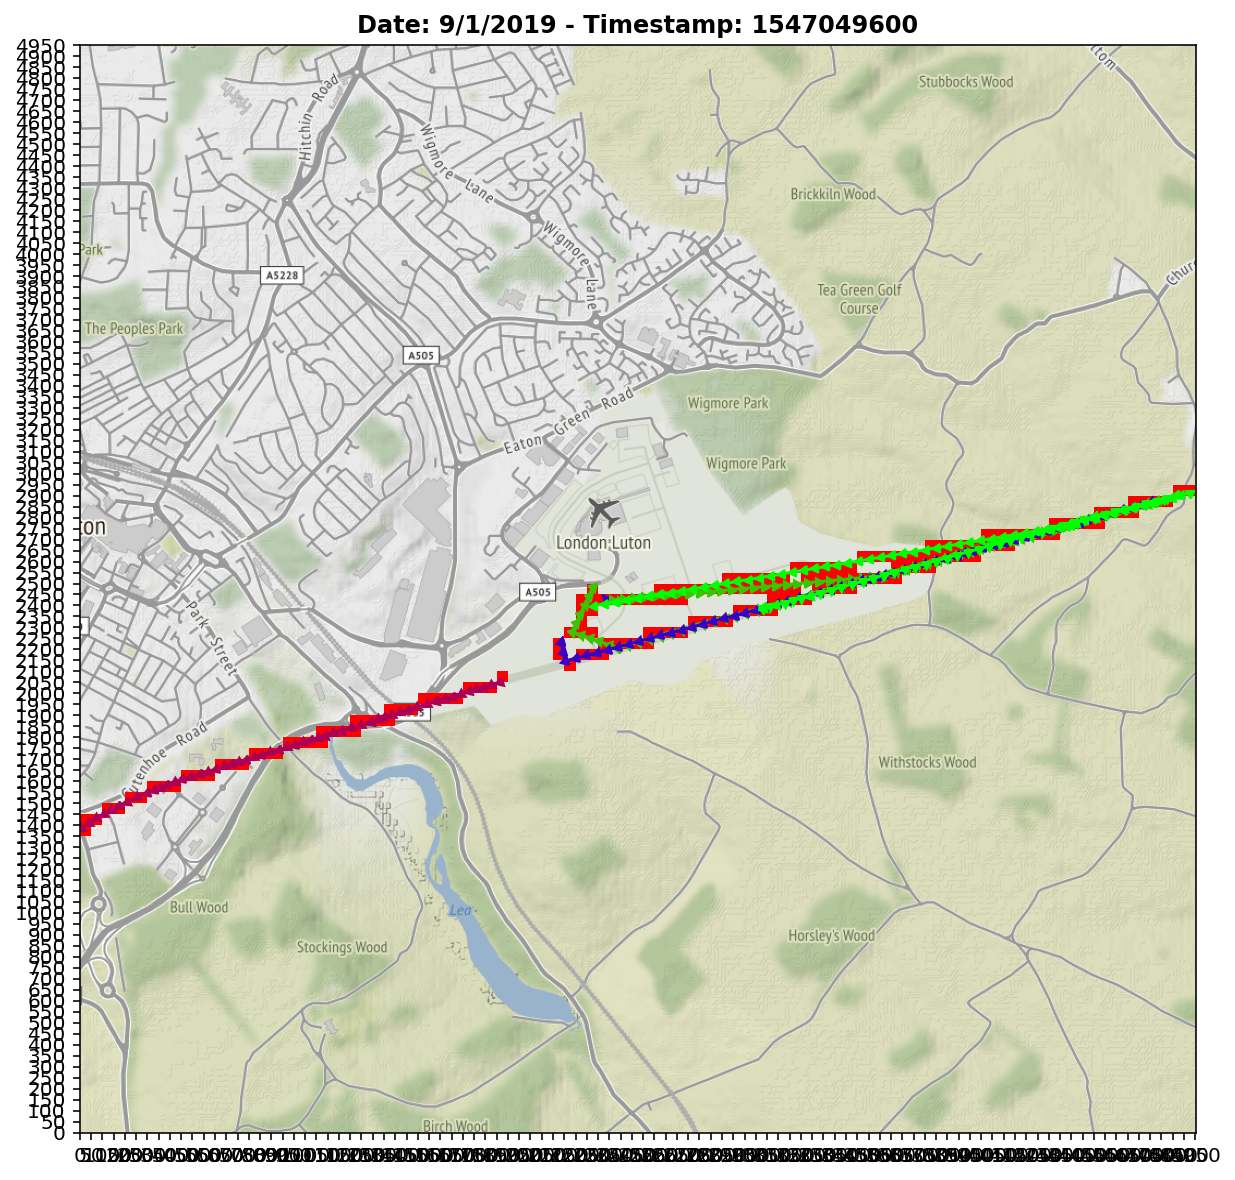

In [39]:
import contextily as cx
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import random
from upsampler.upsampler import upsampler
%config InlineBackend.figure_format = 'retina'

plt.figure()
fig, ax = plt.subplots(figsize=(10,10))

ghent_img, ghent_ext = cx.bounds2img(min_lon, min_lat, max_lon, max_lat, ll=True, source=cx.providers.Stamen.Terrain)
we_distance = haversine(min_coord, (min_lat, max_lon), unit=Unit.METERS)
ns_distance = haversine(min_coord, (max_lat, min_lon), unit=Unit.METERS)

ax.imshow(ghent_img, extent=(0, we_distance, 0, ns_distance))

cmap = plt.cm.get_cmap('brg', 10)
for callsign in callsigns:
  callsign_subset = pd_image_subset[pd_image_subset['callsign'] == callsign].reset_index(drop=True)
  callsign_subset = upsampler(callsign_subset, 50)
  color_index = random.randint(0, 10)
  ax.plot(callsign_subset['we_distance'], callsign_subset['ns_distance'], color=cmap(color_index))

  for k in range(0, len(callsign_subset)):
    ax.plot(callsign_subset['we_distance'][k], callsign_subset['ns_distance'][k], '-', marker=(3, 0, -callsign_subset['heading'][k]), markersize=5, color = cmap(color_index))
    rect = patches.Rectangle((callsign_subset['we_px'][k]*grid_size, callsign_subset['ns_px'][k]*grid_size), grid_size, grid_size, facecolor='red', alpha=1)
    ax.add_patch(rect)

ax.set_title(f'Date: {day}/{month}/{year} - Timestamp: {hour_lookup}', fontweight='bold')
ax.set_xticks(np.arange(0, 5000, grid_size))
ax.set_yticks(np.arange(0, 5000, grid_size))
ax.set_aspect('auto')

# ax.grid(color='black', linewidth = 1, which='both')
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)